## 命名空间与TensorBoard图上节点
为了更好地组织可视化效果图中的计算节点，TensorBoard支持通过TensorFlow命名空间来整理可视化效果图上的界定啊。在TensorBoard的默认视图中，TensorFlow计算图中同一个命名空间下的所有节点会被缩略成一个节点，只有顶层命名空间中的节点才会被显示在TensorBoard可视化效果图上。<br/>

In [4]:
import tensorflow as tf

tf.reset_default_graph()
with tf.name_scope("input1"):
    input1 = tf.constant([1.0, 2.0, 3.0], name="input1")
with tf.name_scope("input2"):
    input2 = tf.Variable(tf.random_uniform([3]), name="input2")
output = tf.add_n([input1, input2], name="add")

writer = tf.summary.FileWriter("./log2", tf.get_default_graph())
writer.close()

In [5]:
# -*- coding : utf-8 -*-
import tensorflow as tf

INPUT_NODES = 784
OUTPUT_NODES = 10
LAYER1_NODES = 500

def get_weight_variable(shape, regularizer):
    weights = tf.get_variable(
        "weights", shape, 
        initializer=tf.truncated_normal_initializer(stddev=0.1))

    if regularizer != None:
        tf.add_to_collection("losses", regularizer(weights))

    return weights

def inference(input_tensor, regularizer):
    with tf.variable_scope("layer1"):
        weights = get_weight_variable(
            [INPUT_NODES, LAYER1_NODES], regularizer)
        bias = tf.get_variable(
            "bias", [LAYER1_NODES],
            initializer=tf.constant_initializer(0.0))

        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + bias)
    
    with tf.variable_scope("layer2"):
        weights = get_weight_variable(
            [LAYER1_NODES, OUTPUT_NODES], regularizer)
        bias = tf.get_variable(
            "bias", [OUTPUT_NODES], 
            initializer=tf.constant_initializer(0.0))
        # 最后一层不使用激活函数！！！！！important
        layer2 = tf.matmul(layer1, weights) + bias

    return layer2

In [9]:
# -*- coding: utf-8 -*-
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 定义神经网络参数
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 30000
MOVING_AVERAGE_DECAY = 0.99
# 模型保存路径
MODLE_SAVE_PATH = './model/'
MODLE_NAME = 'model.ckpt'

def train(mnist):
    # 定义输入输出
    with tf.name_scope("input"):
        x = tf.placeholder(
            tf.float32, [None, INPUT_NODES], name='x-input')
        y_ = tf.placeholder(
            tf.float32, [None, OUTPUT_NODES], name='y-input')
    
    # 定义正则化
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    # 使用mnist_inference定义前向传播
    y = inference(x, regularizer)
    global_step = tf.Variable(0, trainable = False)
    # 定义滑动平均值
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(
            MOVING_AVERAGE_DECAY, global_step)
        variable_averages_op = variable_averages.apply(
            tf.trainable_variables())
    # 定义交叉熵
    with tf.name_scope("loss_function"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=y, labels=tf.argmax(y_, 1))
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        # 定义损失函数
        loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    # 定义学习率
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE, 
            global_step, 
            mnist.train.num_examples / BATCH_SIZE,
            LEARNING_RATE_DECAY)
        # 训练过程
        train_step = tf.train.GradientDescentOptimizer(learning_rate)\
            .minimize(loss, global_step=global_step)
        with tf.control_dependencies([train_step, variable_averages_op]):
            train_op = tf.no_op(name="train")

        # 初始TensorFlow的持久化类
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(TRAINING_STEPS):
                xs, ys = mnist.train.next_batch(BATCH_SIZE)
                _, loss_value, step = sess.run([train_op, loss, global_step], 
                feed_dict={x:xs, y_:ys})
                # 每隔1000次保存一次模型
                if i % 1000 == 0:
                    print('After %d training step(s), loss on training batch is %g.' % (step, loss_value))
                    saver.save(
                        sess, os.path.join(MODLE_SAVE_PATH, MODLE_NAME),
                        global_step=global_step)
    writer = tf.summary.FileWriter('./log3', tf.get_default_graph())
    writer.close()
    
def main(argv=None):
    mnist = input_data.read_data_sets("../Data/", one_hot=True)
    train(mnist)

if __name__ == "__main__":
    # 报An exception has occurred, use %tb to 
    # see the full traceback.错误
    #tf.app.run()
    tf.reset_default_graph()
    main()

Extracting ../Data/train-images-idx3-ubyte.gz
Extracting ../Data/train-labels-idx1-ubyte.gz
Extracting ../Data/t10k-images-idx3-ubyte.gz
Extracting ../Data/t10k-labels-idx1-ubyte.gz
After 1 training step(s), loss on training batch is 3.45427.
After 1001 training step(s), loss on training batch is 0.281819.
After 2001 training step(s), loss on training batch is 0.167006.
After 3001 training step(s), loss on training batch is 0.144066.
After 4001 training step(s), loss on training batch is 0.13068.
After 5001 training step(s), loss on training batch is 0.114805.
After 6001 training step(s), loss on training batch is 0.106094.
After 7001 training step(s), loss on training batch is 0.086628.
After 8001 training step(s), loss on training batch is 0.0803836.
After 9001 training step(s), loss on training batch is 0.0770782.
After 10001 training step(s), loss on training batch is 0.0706015.
After 11001 training step(s), loss on training batch is 0.0618765.
After 12001 training step(s), loss on

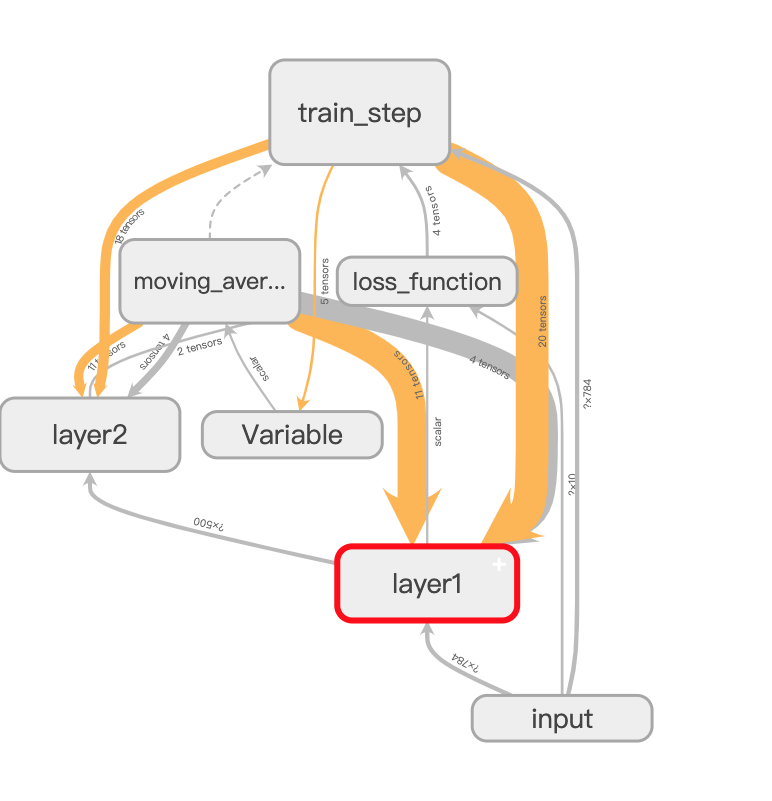
节点之间的连接：<br/>
1. 通过`实线`表示。这种边刻画数据传输，边上箭头方向表示数据传输方向。<br/>
2. 边的粗细表示的是两个节点之间传输的标量维度的总大小，而不是传输的标量的个数。当张量的维度无法确定时，TensorBoard会使用最细的边表示。比如layer2和train_step虽然传输了6个张量，但其维度都比较小，所以比layer1和moving_average之间的边(只传输4个张量)还要细。<br/>
3. 通过`虚线`表示。虚边表达了计算之间的依赖关系。比如程序中，通过tf.control_dependencies函数指定了更新参数滑动平均值的操作和通过反向传播更新变量的操作需要同时进行，于是moving_average与train_step之间存在一条虚边。<br/>
除了手动的通过TensorFlow中的命名空间来调整TensorBoad的可视化效果图，TensorBoard会智能地调整可视化效果图上的节点。TensorFlow中部分计算节点会有比较多的依赖关系，如果全部画在一张图上会使可视化得到的效果图非常拥挤。于是TensorBoard将TensorFlow计算图分成`主图(Main Graph)`和`辅助图(Auxiliary nodes)`两部分来呈现。TensorBoad会自动将连接比较多的节点放在辅助图中，使得主图结构更加清晰。<br/>
除了自动方式，TensorBoad也支持手工的方式来调整可视化结果。右击节点->加入主图或从主图删除。<br/>

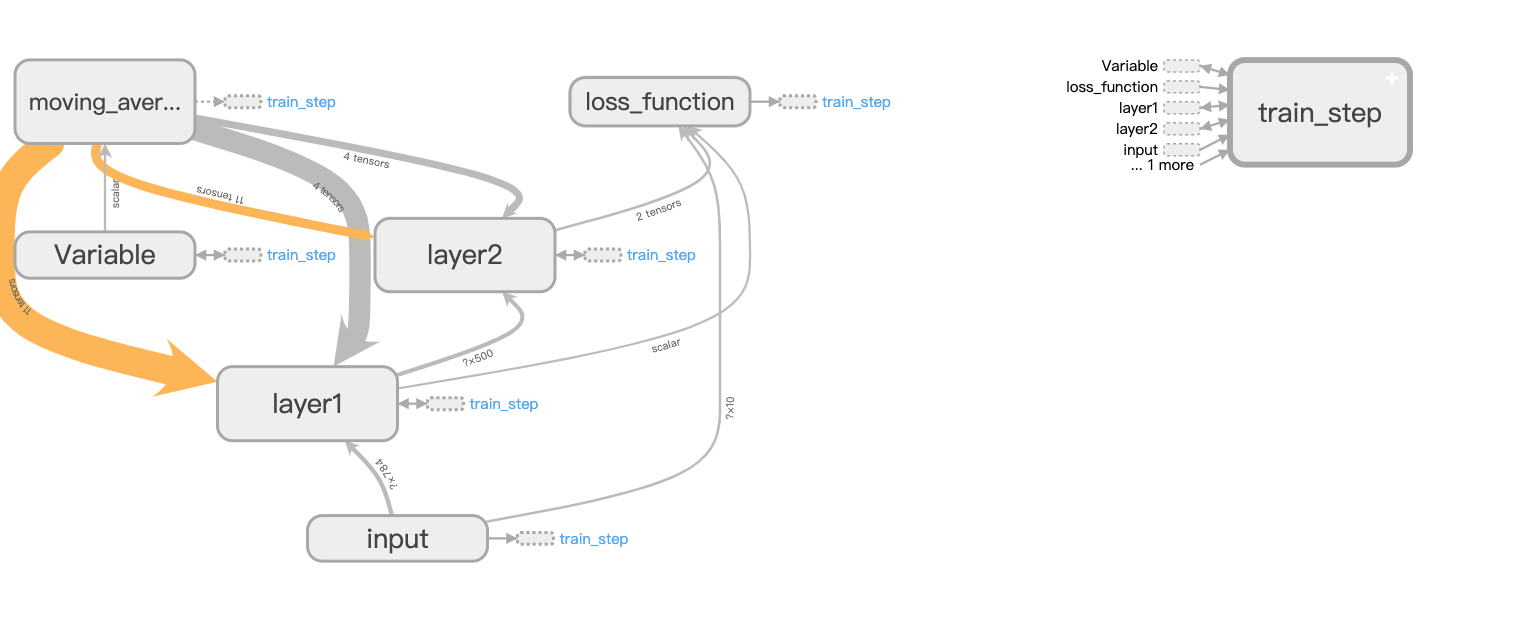
## 节点信息
使用TensorBoad可以直观展示所有TensorFlow计算节点在某一次运行时所消耗的时间和内存，这样可以更加有针对性的优化TensorFlow程序。<br/>

In [11]:
# -*- coding: utf-8 -*-
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 定义神经网络参数
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 30000
MOVING_AVERAGE_DECAY = 0.99
# 模型保存路径
MODLE_SAVE_PATH = './model/'
MODLE_NAME = 'model.ckpt'

def train(mnist):
    # 定义输入输出
    with tf.name_scope("input"):
        x = tf.placeholder(
            tf.float32, [None, INPUT_NODES], name='x-input')
        y_ = tf.placeholder(
            tf.float32, [None, OUTPUT_NODES], name='y-input')
    
    # 定义正则化
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    # 使用mnist_inference定义前向传播
    y = inference(x, regularizer)
    global_step = tf.Variable(0, trainable = False)
    # 定义滑动平均值
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(
            MOVING_AVERAGE_DECAY, global_step)
        variable_averages_op = variable_averages.apply(
            tf.trainable_variables())
    # 定义交叉熵
    with tf.name_scope("loss_function"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=y, labels=tf.argmax(y_, 1))
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        # 定义损失函数
        loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    # 定义学习率
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE, 
            global_step, 
            mnist.train.num_examples / BATCH_SIZE,
            LEARNING_RATE_DECAY)
        # 训练过程
        train_step = tf.train.GradientDescentOptimizer(learning_rate)\
            .minimize(loss, global_step=global_step)
        with tf.control_dependencies([train_step, variable_averages_op]):
            train_op = tf.no_op(name="train")

        # 初始TensorFlow的持久化类
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            writer = tf.summary.FileWriter('./log4', tf.get_default_graph())
            for i in range(TRAINING_STEPS):
                xs, ys = mnist.train.next_batch(BATCH_SIZE)
                # 每隔1000次保存一次模型
                if i % 1000 == 0:
                    # 配置运行时需要记录的信息
                    run_options = tf.RunOptions(
                        trace_level=tf.RunOptions.FULL_TRACE)
                    # 运行时记录运行信息的proto
                    run_metadata = tf.RunMetadata()
                    # 将配置信息和记录运行信息的proto传入运行的过程，从而记录运行时
                    # 每一个节点的时间、空间开销信息
                    _, loss_value, step = sess.run(
                        [train_op, loss, global_step], feed_dict={x:xs, y_:ys}, 
                        options=run_options, run_metadata = run_metadata)
                    # 将节点在运行时的信息写入日志文件
                    writer.add_run_metadata(run_metadata, 'step%03d' % i)
                    print('After %d training step(s), loss on training batch is %g.' % (step, loss_value))
                    saver.save(
                        sess, os.path.join(MODLE_SAVE_PATH, MODLE_NAME),
                        global_step=global_step)
                else:
                     _, loss_value, step = sess.run([train_op, loss, global_step], 
                                                    feed_dict={x:xs, y_:ys})
    writer.close()
    
def main(argv=None):
    mnist = input_data.read_data_sets("../Data/", one_hot=True)
    train(mnist)

if __name__ == "__main__":
    # 报An exception has occurred, use %tb to 
    # see the full traceback.错误
    #tf.app.run()
    tf.reset_default_graph()
    main()

Extracting ../Data/train-images-idx3-ubyte.gz
Extracting ../Data/train-labels-idx1-ubyte.gz
Extracting ../Data/t10k-images-idx3-ubyte.gz
Extracting ../Data/t10k-labels-idx1-ubyte.gz
After 1 training step(s), loss on training batch is 3.11898.
After 1001 training step(s), loss on training batch is 0.215443.
After 2001 training step(s), loss on training batch is 0.230454.
After 3001 training step(s), loss on training batch is 0.167137.
After 4001 training step(s), loss on training batch is 0.117904.
After 5001 training step(s), loss on training batch is 0.107891.
After 6001 training step(s), loss on training batch is 0.102292.
After 7001 training step(s), loss on training batch is 0.0899642.
After 8001 training step(s), loss on training batch is 0.0764532.
After 9001 training step(s), loss on training batch is 0.073113.
After 10001 training step(s), loss on training batch is 0.0654062.
After 11001 training step(s), loss on training batch is 0.0695786.
After 12001 training step(s), loss o

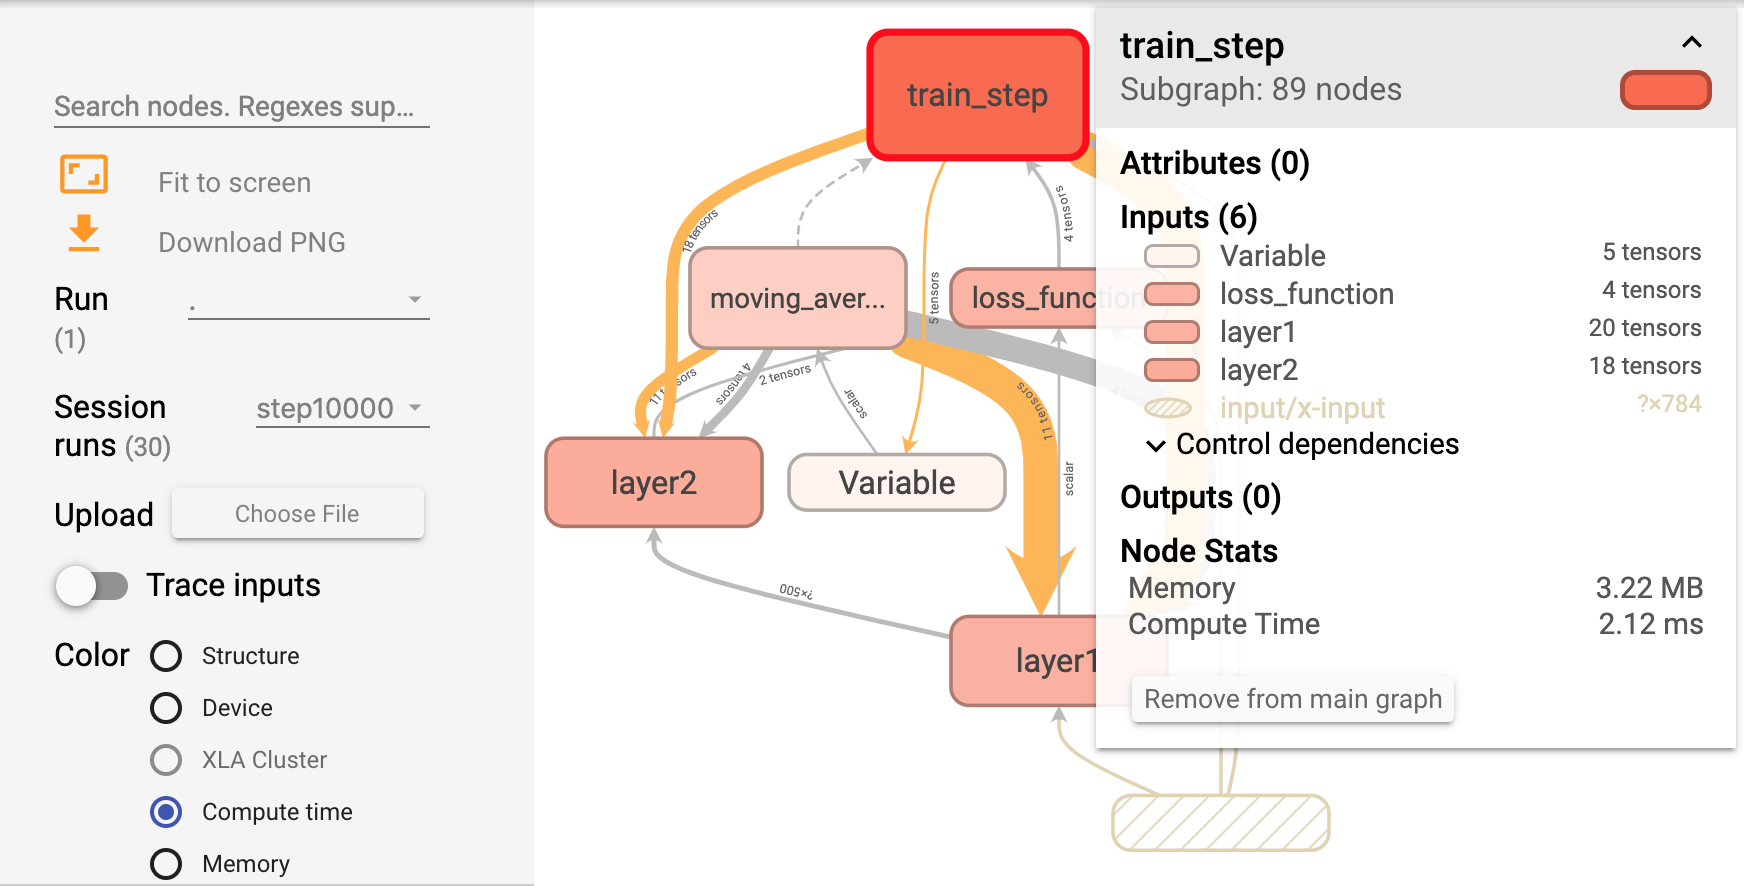
在Color栏选择Compute time可以看到这次运行中每个TensorFlow计算节点的运行时间，颜色越深的节点表示时间消耗越大。通过对每个计算节点消耗时间的可视化，可以很容易找到TensorFlow计算图上的性能瓶颈，这方便了优化工作。在性能调优时，一般会选择迭代次数较大时的数据作为不同计算节点时间/空间消耗标准，因为这样可以减少TensorFlow初始化对性能的影响。<br/>
TensorBoad默认展示的可视化效果图默认是`Structure`，灰色的节点表示没有其他节点的和它有相同结构，如果有两个节点的结构相同，则具有相同颜色。`Device`选项，根据TensorFlow计算节点运行的机器给可视化效果图上的节点染色。在使用GPU时，可以通过这种方式直观看到哪些计算节点被放到GPU上。<br/>